# 1 Imports

In [1]:
from torch.utils.data import Dataset
from PIL import Image as PILImage
import numpy as np
import torch

from abc import ABC, abstractmethod
from dataclasses import dataclass
from os import PathLike
import os

# Constants

In [2]:
BASE_DIR = os.path.abspath("")
ROOT_DIR = os.path.dirname(BASE_DIR)
KZ_BASE_DIR = os.path.join(ROOT_DIR, "DJI_202507131523_004")

TRAIN_MODEL = False
USE_PRECOMPUTED_CLASS_WEIGHTS = True

IMAGE_WIDTH = IMAGE_HEIGHT = 512
RGBN_CHANNELS = 4

LABELS = [
    "double_plant",
    "drydown",
    "endrow",
    "nutrient_deficiency",
    "waterway",
    "water",
    "planter_skip",
    "weed_cluster",
    "storm_damage",
]

EXCLUDE_LABELS = ["storm_damage"]
CLASSES_COUNT = len(LABELS) - len(EXCLUDE_LABELS)

print(ROOT_DIR)
print(BASE_DIR, KZ_BASE_DIR)
print(f"Classes count: {CLASSES_COUNT}")

c:\Users\Max\Files\Projects\AgriNet-Research\agrinet\datasets
c:\Users\Max\Files\Projects\AgriNet-Research\agrinet\datasets\Agriculture-Vision-2021 c:\Users\Max\Files\Projects\AgriNet-Research\agrinet\datasets\DJI_202507131523_004
Classes count: 8


In [3]:
dataset_name = "_dataset"
kz_dataset_name = "_dataset"

dataset_path = os.path.join(BASE_DIR, dataset_name)
kz_dataset_path = os.path.join(KZ_BASE_DIR, kz_dataset_name)

dataset_train_path = os.path.join(dataset_path, "train")
dataset_val_path = os.path.join(dataset_path, "val")

dataset_test_path = os.path.join(dataset_path, "test")
kz_dataset_test_path = os.path.join(kz_dataset_path, "test")

# Train dataset paths
IMAGE_DIRS = [
    os.path.join(dataset_train_path, "images", "rgbn"),
    os.path.join(dataset_train_path, "aug_images", "rgbn"),
]

LABEL_DIRS = [
    os.path.join(dataset_train_path, "labels"),
    os.path.join(dataset_train_path, "aug_labels"),
]

# Validation dataset paths
# NOTE: Each label has a folder for each class (labels/class_x, etc.)
VAL_IMAGE_RGB_DIR = os.path.join(dataset_val_path, "images", "rgb")
VAL_IMAGE_NIR_DIR = os.path.join(dataset_val_path, "images", "nir")
VAL_LABEL_DIRS = [
    os.path.join(dataset_val_path, "labels"),
]

# Test dataset paths
INCLUDE_US_TEST_DATASET = True
INCLUDE_KZ_TEST_DATASET = False

TEST_IMAGE_RGB_DIRS = []
TEST_IMAGE_NIR_DIRS = []

if INCLUDE_US_TEST_DATASET:
    TEST_IMAGE_RGB_DIRS.append(os.path.join(dataset_test_path, "images", "rgb"))
    TEST_IMAGE_NIR_DIRS.append(os.path.join(dataset_test_path, "images", "nir"))

if INCLUDE_KZ_TEST_DATASET:
    TEST_IMAGE_RGB_DIRS.append(os.path.join(kz_dataset_test_path, "images", "rgb"))
    TEST_IMAGE_NIR_DIRS.append(os.path.join(kz_dataset_test_path, "images", "nir"))

print(dataset_path, kz_dataset_path)

c:\Users\Max\Files\Projects\AgriNet-Research\agrinet\datasets\Agriculture-Vision-2021\_dataset c:\Users\Max\Files\Projects\AgriNet-Research\agrinet\datasets\DJI_202507131523_004\_dataset


# Image classes

In [4]:
class ImageSource(ABC):
    @abstractmethod
    def load(self) -> torch.Tensor:
        raise NotImplementedError

    @staticmethod
    def _load_image_from_numpy(arr: np.ndarray) -> torch.Tensor:
        return torch.from_numpy(arr.astype(np.float32))

    @classmethod
    def _load_image_from_path(cls, path: str | PathLike) -> torch.Tensor:
        arr = np.array(PILImage.open(path))
        return cls._load_image_from_numpy(arr)
    
    def __repr__(self) -> str:
        return self.__class__.__name__

class Image(ImageSource):
    pass

class Mask(ImageSource):
    pass
    
@dataclass
class ImageData:
    image_id: str
    image: Image
    mask: Mask

In [5]:
class RGBImagePlusNIR(Image):
    """ RGB Image with an additional Near-Infrared (NIR) channel."""

    def __init__(self, rgb_path: str, nir_path: str, normalize=True):
        self.rgb_path = rgb_path
        self.nir_path = nir_path
        self.normalize = normalize
        
    def load(self) -> torch.Tensor:
        rgb = self._load_image_from_path(self.rgb_path).permute(2, 0, 1)  # (3, H, W)
        nir = self._load_image_from_path(self.nir_path).unsqueeze(0)      # (1, H, W)
        img = torch.cat([rgb, nir], dim=0)  # (4, H, W)
        
        if self.normalize:
            img = img / 255.0  # Normalize to [0, 1]
        
        return img


class RGBNImage(Image):
    """Png image with 4 channels: Red, Green, Blue, Near-Infrared (NIR)."""

    def __init__(self, rgbn_path: str, normalize=True):
        if not self._is_png_image(rgbn_path):
            raise ValueError(f"RGBNImage only supports PNG images. Given file: {rgbn_path}")
        
        self.rgbn_path = rgbn_path
        self.normalize = normalize
        
    def load(self) -> torch.Tensor:
        img = self._load_image_from_path(self.rgbn_path).permute(2, 0, 1)
        
        if self.normalize:
            img = img / 255.0  # Normalize to [0, 1]
        
        return img
    
    @staticmethod
    def _is_png_image(file_path: str) -> bool:
        return file_path.lower().endswith('.png')

In [6]:
class MultiLabelMask(Mask):
    """Multi-label mask where labels CAN overlap (no mutual exclusivity)."""
    
    def __init__(self, *mask_paths: str, labels_order: list[str] | None = None):
        paths = list(mask_paths)
        if labels_order:
            self._mask_paths = self._sort_by_labels(paths, labels_order)
        else:
            self._mask_paths = sorted(paths)
        self._labels_count = len(self._mask_paths)

    def get_label_order(self) -> list[str]:
        return [self._get_label_from_path(p) for p in self._mask_paths]

    @staticmethod
    def _get_label_from_path(path: str) -> str:
        return os.path.basename(os.path.dirname(path)).lower()

    @classmethod
    def _sort_by_labels(cls, mask_paths: list[str], labels_order: list[str]) -> list[str]:
        path_by_label = {}
        for path in mask_paths:
            label = cls._get_label_from_path(path)
            path_by_label[label] = path

        sorted_paths = []
        for label in labels_order:
            label_lower = label.lower()
            if label_lower in path_by_label:
                sorted_paths.append(path_by_label[label_lower])
        return sorted_paths

    def load(self) -> torch.Tensor:
        tensors = []
        for mask_path in self._mask_paths:
            image = self._load_image_from_path(mask_path)
            mask = (image > 0).float().unsqueeze(0)  # (1, H, W)
            tensors.append(mask)
        
        return torch.cat(tensors, dim=0)

    def __str__(self) -> str:
        return f"{self.__class__.__name__}(classes={self._labels_count})"

In [7]:
class EmptyMask(Mask):
    def __init__(self, h: int, w: int, classes: int):
        self.h = h
        self.w = w
        self.classes = classes

    def load(self) -> torch.Tensor:
        return torch.zeros(self.classes, self.h, self.w, dtype=torch.float32)

# ImageIdsParser

In [8]:
class ImageIdsParser:
    @classmethod
    def get_ids_for_dirs(cls, dirs: list[str]) -> list[str]:
        ids = []
        for d in dirs:
            ids.extend(cls.get_ids_for_dir(d))
        return ids
    
    @classmethod
    def get_ids_for_dir(cls, path: str) -> list[str]:
        ids_with_nones = [cls._get_id_from_image_path(p) for p in cls._get_items_by_path(path)]
        ids = [i for i in ids_with_nones if i]
        return ids
    
    @classmethod
    def _get_id_from_image_path(cls, path: str) -> str | None:
        try:
            return path.split(".")[0]  # id-with-coords.png
        except IndexError:
            return None
    
    @classmethod
    def _get_items_by_path(cls, path: str) -> list[str]:
        try:
            return os.listdir(path)
        except FileNotFoundError:
            print(f"[WARNING] Path not found: {path}")
            return []

In [9]:
IMAGE_IDS = ImageIdsParser.get_ids_for_dirs(IMAGE_DIRS)
print(f"Found {len(IMAGE_IDS)} image IDs.")

Found 156397 image IDs.


In [10]:
VAL_IMAGE_IDS = ImageIdsParser.get_ids_for_dirs([VAL_IMAGE_RGB_DIR])
print(f"Found {len(VAL_IMAGE_IDS)} validation image IDs.")

Found 18334 validation image IDs.


In [11]:
TEST_IMAGE_IDS = ImageIdsParser.get_ids_for_dirs(TEST_IMAGE_RGB_DIRS)
print(f"Found {len(TEST_IMAGE_IDS)} test image IDs. Including KZ dataset: {INCLUDE_KZ_TEST_DATASET}")

Found 19708 test image IDs. Including KZ dataset: False


# Dataset Abstraction

In [12]:
class SegmentationDataset(ABC, Dataset):
    def __init__(self, image_ids: list[str]) -> None: 
        self._image_ids = image_ids

    def __len__(self) -> int:
        return len(self._image_ids)
        
    def __getitem__(self, idx: int):
        image_id = self._image_ids[idx]
        data = self.get_data(image_id)

        img = data.image.load()
        mask = data.mask.load()
        
        # Validate shapes match
        if img.shape[-2:] != mask.shape[-2:]:
            raise ValueError(
                f"Shape mismatch for {image_id}: "
                f"image {img.shape} vs mask {mask.shape}"
            )
        
        return img, mask

    def first(self) -> ImageData | None:
        try:
            first_id = self._image_ids[0]
            return self.get_data(first_id)
        except IndexError:
            return None
    
    @abstractmethod
    def get_data(self, image_id: str) -> ImageData:
        raise NotImplementedError

# File Searcher

In [13]:
class FileSearcher:
    def __init__(self, search_paths: list[str], exclude_patterns: list[str] | None = None):
        self.search_paths = search_paths
        self.exclude_patterns = exclude_patterns or []
        self._cache = self._build_index()
    
    def _build_index(self) -> dict[str, list[str]]:
        """Build filename -> paths mapping once, excluding specified patterns"""
        index = {}
        for root_folder in self.search_paths:
            for dirpath, _, filenames in os.walk(root_folder):
                
                # Check if current dirpath should be excluded
                if self._should_exclude(dirpath):
                    continue
                    
                for filename in filenames:
                    full_path = os.path.join(dirpath, filename)
                    
                    key = filename.lower()
                    if key not in index:
                        index[key] = []
                    index[key].append(full_path)
        return index
    
    def _should_exclude(self, path: str) -> bool:
        """Check if path contains any exclude patterns"""
        path_lower = path.lower()
        should_exclude = any(pattern.lower() in path_lower for pattern in self.exclude_patterns)

        if should_exclude:
            print(f"Exclude path from search: {path}")
        
        return should_exclude
    
    def search(self, file_name: str) -> list[str]:
        return self._cache.get(file_name.lower(), [])

# Datasets

In [14]:
class TrainDataset(SegmentationDataset):
    EXPECTED_MASKS_COUNT = CLASSES_COUNT
    
    _image_searcher = FileSearcher(IMAGE_DIRS)
    _mask_searcher = FileSearcher(
        LABEL_DIRS, 
        exclude_patterns=EXCLUDE_LABELS,
    )
    
    def __init__(self, image_ids: list[str]) -> None: 
        super().__init__(image_ids=image_ids)
    
    def get_data(self, image_id: str) -> ImageData:
        return ImageData(
            image_id=image_id,
            image=self._get_image(image_id),
            mask=self._get_mask(image_id),
        )
    
    def _get_image(self, image_id: str) -> Image:
        file_name = self._get_file_name(image_id)
        rgbn_paths = self._image_searcher.search(file_name)

        if len(rgbn_paths) == 0 or len(rgbn_paths) > 1:
            raise Exception(f"Expected exactly one RGBN image for ID '{image_id}', found {len(rgbn_paths)}.")

        return RGBNImage(rgbn_paths[0])

    def _get_mask(self, image_id: str) -> Mask:
        file_name = self._get_file_name(image_id)
        masks = self._mask_searcher.search(file_name)
        if not masks:
            raise Exception(f"No masks found for image ID '{image_id}'.")
        self._validate_masks(masks)
        return MultiLabelMask(*masks, labels_order=LABELS)

    @classmethod
    def _validate_masks(cls, masks: list[str]) -> None:
        found = len(masks)
        expected = cls.EXPECTED_MASKS_COUNT

        if found != expected:
            raise Exception(f"Failed parse masks, {expected=}, {found=}")
    
    @staticmethod
    def _get_file_name(image_id: str) -> str:
        return f"{image_id}.png"


def _test() -> None:
    train_dataset = TrainDataset(image_ids=IMAGE_IDS)
    image_data = train_dataset.first()

    print(f"Loaded {len(train_dataset)} instances")
    
    if image_data:
        print(image_data)

        print("Labels order in mask tensor")
        print(image_data.mask.get_label_order())

_test()

Exclude path from search: c:\Users\Max\Files\Projects\AgriNet-Research\agrinet\datasets\Agriculture-Vision-2021\_dataset\train\labels\storm_damage
Exclude path from search: c:\Users\Max\Files\Projects\AgriNet-Research\agrinet\datasets\Agriculture-Vision-2021\_dataset\train\aug_labels\storm_damage
Loaded 156397 instances
ImageData(image_id='11IE4DKTR_11556-9586-12068-10098', image=RGBNImage, mask=MultiLabelMask)
Labels order in mask tensor
['double_plant', 'drydown', 'endrow', 'nutrient_deficiency', 'waterway', 'water', 'planter_skip', 'weed_cluster']


In [15]:
class ValidationDataset(SegmentationDataset):
    EXPECTED_MASKS_COUNT = CLASSES_COUNT

    _rgb_searcher = FileSearcher([VAL_IMAGE_RGB_DIR])
    _nir_searcher = FileSearcher([VAL_IMAGE_NIR_DIR])
    _mask_searcher = FileSearcher(
        VAL_LABEL_DIRS,
        exclude_patterns=EXCLUDE_LABELS,
    )

    def __init__(self, image_ids: list[str]) -> None:
        super().__init__(image_ids=image_ids)

    def get_data(self, image_id: str) -> ImageData:
        return ImageData(
            image_id=image_id,
            image=self._get_image(image_id),
            mask=self._get_mask(image_id),
        )

    def _get_image(self, image_id: str) -> Image:
        file_name = self._get_file_name(image_id)

        rgb_paths = self._rgb_searcher.search(file_name)
        nir_paths = self._nir_searcher.search(file_name)

        if len(rgb_paths) != 1 or len(nir_paths) != 1:
            raise Exception(
                f"Expected exactly one RGB and one NIR image for ID '{image_id}', "
                f"found rgb={len(rgb_paths)}, nir={len(nir_paths)}."
            )

        return RGBImagePlusNIR(rgb_path=rgb_paths[0], nir_path=nir_paths[0])

    def _get_mask(self, image_id: str) -> Mask:
        file_name = self._get_mask_file_name(image_id)
        masks = self._mask_searcher.search(file_name)
        if not masks:
            raise Exception(f"No masks found for image ID '{image_id}'.")
        self._validate_masks(masks)
        return MultiLabelMask(*masks, labels_order=LABELS)

    @classmethod
    def _validate_masks(cls, masks: list[str]) -> None:
        found = len(masks)
        expected = cls.EXPECTED_MASKS_COUNT

        if found != expected:
            raise Exception(f"Failed parse masks, expected={expected}, found={found}")

    @staticmethod
    def _get_file_name(image_id: str) -> str:
        return f"{image_id}.jpg"
    
    @staticmethod
    def _get_mask_file_name(image_id: str) -> str:
        return f"{image_id}.png"

def _test() -> None:
    val_dataset = ValidationDataset(image_ids=VAL_IMAGE_IDS)
    image_data = val_dataset.first()

    print(f"Loaded {len(val_dataset)} instances in validation dataset")

    if image_data:
        print(image_data)

_test()

Exclude path from search: c:\Users\Max\Files\Projects\AgriNet-Research\agrinet\datasets\Agriculture-Vision-2021\_dataset\val\labels\storm_damage
Loaded 18334 instances in validation dataset
ImageData(image_id='138GZZR3U_2368-12251-2880-12763', image=RGBImagePlusNIR, mask=MultiLabelMask)


In [16]:
class TestDataset(SegmentationDataset):
    _rgb_searcher = FileSearcher(TEST_IMAGE_RGB_DIRS)
    _nir_searcher = FileSearcher(TEST_IMAGE_NIR_DIRS)
    _dummy_mask_width = IMAGE_WIDTH
    _dummy_mask_height = IMAGE_HEIGHT

    def __init__(self, image_ids: list[str]) -> None:
        super().__init__(image_ids=image_ids)

    def get_data(self, image_id: str) -> ImageData:
        image = self._get_image(image_id)
        mask = EmptyMask(
            h=self._dummy_mask_height,
            w=self._dummy_mask_width,
            classes=CLASSES_COUNT,
        )

        return ImageData(image_id=image_id, image=image, mask=mask)

    def _get_image(self, image_id: str) -> Image:
        file_name_png = f"{image_id}.png"
        file_name_jpg = f"{image_id}.jpg"

        rgb_paths = self._rgb_searcher.search(file_name_jpg) + self._rgb_searcher.search(file_name_png)
        nir_paths = self._nir_searcher.search(file_name_jpg) + self._nir_searcher.search(file_name_png)

        if len(rgb_paths) == 1 and len(nir_paths) == 1:
            return RGBImagePlusNIR(rgb_path=rgb_paths[0], nir_path=nir_paths[0])
        
        raise Exception(f"Failed to resolve test image for ID '{image_id}': rgb={len(rgb_paths)}, nir={len(nir_paths)}")

def _test() -> None:
    test_dataset = TestDataset(image_ids=TEST_IMAGE_IDS)
    image_data = test_dataset.first()

    print(f"Loaded {len(test_dataset)} instances in test dataset")

    if image_data:
        print(image_data)

_test()

Loaded 19708 instances in test dataset
ImageData(image_id='17FCUVCMI_1728-7254-2240-7766', image=RGBImagePlusNIR, mask=EmptyMask)


# Train Model

In [17]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

In [18]:
NUM_WORKERS = min(0, os.cpu_count() or 1)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda


In [19]:
BACKBONE_MODEL = "mobilenet_v2"  # efficientnet-b3

CONFIG = {
    # Training
    "epochs": 50,
    "batch_size": 16 if DEVICE.type == "cuda" else 2,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    
    # Model
    "encoder": BACKBONE_MODEL,
    "in_channels": 4,  # RGBN
    "classes": CLASSES_COUNT,
    
    # Loss
    "bce_weight": 0.5,
    "dice_weight": 0.5,
    
    # Early stopping
    "patience": 10,
    
    # Threshold for predictions
    "threshold": 0.5,
}

In [20]:
class CombinedLoss(nn.Module):
    """Combined BCE + Dice Loss for multi-label segmentation."""

    def __init__(self, bce_weight=0.5, dice_weight=0.5, class_weights=None):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        
        # Store class weights for manual weighting
        if class_weights is not None:
            if not isinstance(class_weights, torch.Tensor):
                class_weights = torch.tensor(class_weights, dtype=torch.float32)
            # Ensure it's 1D and detached
            self.register_buffer('class_weights', class_weights.detach().clone().view(-1))
        else:
            self.class_weights = None
        
        # Use BCE without pos_weight, we'll apply weights manually
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def dice_loss(self, pred, target, smooth=1.0):
        """Dice loss for multi-label."""
        pred = torch.sigmoid(pred)

        # Flatten per class
        pred_flat = pred.view(pred.size(0), pred.size(1), -1)
        target_flat = target.view(target.size(0), target.size(1), -1)

        intersection = (pred_flat * target_flat).sum(dim=2)
        union = pred_flat.sum(dim=2) + target_flat.sum(dim=2)

        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

    def forward(self, pred, target):
        # Compute BCE loss without reduction
        bce = self.bce(pred, target)  # Shape: (B, C, H, W)
        
        # Apply class weights if available
        if self.class_weights is not None:
            # Reshape weights for broadcasting: (1, C, 1, 1)
            weights = self.class_weights.view(1, -1, 1, 1)
            bce = bce * weights
        
        # Take mean across all dimensions
        bce = bce.mean()
        
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

In [21]:
def compute_class_weights(dataloader, num_classes) -> torch.Tensor:
    """Compute inverse frequency weights for class imbalance."""
    print("Computing class weights...")
    class_pixels = torch.zeros(num_classes)
    total_pixels = 0
    
    for _, masks in tqdm(dataloader, desc="Analyzing class distribution"):
        for c in range(num_classes):
            class_pixels[c] += masks[:, c, :, :].sum()
        total_pixels += masks.numel() // num_classes
    
    # Inverse frequency weighting
    class_freq = class_pixels / total_pixels
    class_weights = 1.0 / (class_freq + 1e-6)
    class_weights = class_weights / class_weights.sum() * num_classes  # Normalize
    
    print(f"Class weights: {class_weights.tolist()}")
    return class_weights

In [22]:
def compute_metrics(preds, targets, threshold=0.5, num_classes=CLASSES_COUNT):
    """Compute per-class IoU and mIoU for multi-label segmentation."""
    preds = torch.sigmoid(preds) > threshold

    ious = []
    for c in range(num_classes):
        pred_c = preds[:, c, :, :].bool()
        target_c = targets[:, c, :, :].bool()

        intersection = (pred_c & target_c).sum().float()
        union = (pred_c | target_c).sum().float()

        if union > 0:
            iou = intersection / union
            ious.append(iou.item())
        else:
            continue

    return ious if ious else [0.0]

In [23]:
def train_one_epoch(model, dataloader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(dataloader, desc="Training")
    for images, masks in pbar:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with autocast(device_type=device.type, enabled=device.type == "cuda"):
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return running_loss / len(dataloader)

In [24]:
@torch.no_grad()
def validate(model, dataloader, criterion, device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    
    # Accumulate per-class intersections and unions across ALL batches
    num_classes = CLASSES_COUNT
    total_intersection = torch.zeros(num_classes)
    total_union = torch.zeros(num_classes)

    for images, masks in tqdm(dataloader, desc="Validating"):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        with autocast(device_type=device.type, enabled=device.type == "cuda"):
            outputs = model(images)
            loss = criterion(outputs, masks)

        running_loss += loss.item()

        # Compute predictions
        preds = torch.sigmoid(outputs) > threshold
        preds = preds.cpu()
        masks_cpu = masks.cpu()
        
        # Accumulate per-class metrics
        for c in range(num_classes):
            pred_c = preds[:, c, :, :].bool()
            target_c = masks_cpu[:, c, :, :].bool()
            
            total_intersection[c] += (pred_c & target_c).sum().float()
            total_union[c] += (pred_c | target_c).sum().float()

    # Compute IoU for each class
    ious = []
    for c in range(num_classes):
        if total_union[c] > 0:
            iou = (total_intersection[c] / total_union[c]).item()
            ious.append(iou)
        # else: skip classes with no samples
    
    avg_loss = running_loss / len(dataloader)
    avg_miou = np.mean(ious) if ious else 0.0
    
    # Debug info
    print(f"\nPer-class IoU: {[f'{iou:.4f}' for iou in ious]}")
    print(f"Classes evaluated: {len(ious)}/{num_classes}")

    return avg_loss, avg_miou

In [25]:
train_dataset = TrainDataset(image_ids=IMAGE_IDS)
val_dataset = ValidationDataset(image_ids=VAL_IMAGE_IDS)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=NUM_WORKERS > 0,
    drop_last=True,  # Important for BatchNorm
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# Model
model = smp.DeepLabV3Plus(
    encoder_name=CONFIG["encoder"],
    encoder_weights="imagenet",
    in_channels=CONFIG["in_channels"],
    classes=CONFIG["classes"],
).to(DEVICE)


In [26]:
BEST_MODEL_PATH = f"best_model_{BACKBONE_MODEL}{dataset_name}.pth"

def train_model():
    # Compute class weights for imbalance handling
    
    if not USE_PRECOMPUTED_CLASS_WEIGHTS:
        # Claculate class weights from the training dataset
        class_weights = compute_class_weights(train_loader, CONFIG["classes"])
    else:
        # Pre-computed class weights based on dataset analysis
        class_weights = torch.tensor([
            1.3280059099197388,
            0.3596874177455902,
            0.9668537974357605,
            0.29658055305480957,
            0.9289456009864807,
            0.5627424716949463,
            3.245534658432007,
            0.311649352312088
        ], dtype=torch.float32)

    # Loss with class weights
    criterion = CombinedLoss(
        bce_weight=CONFIG["bce_weight"],
        dice_weight=CONFIG["dice_weight"],
        class_weights=class_weights.to(DEVICE),
    )

    # Optimizer
    optimizer = AdamW(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"],
    )

    # Scheduler
    scheduler = CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )

    # Mixed precision scaler
    scaler = GradScaler()

    # Training tracking
    best_miou = 0.0
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_miou": []}
    
    print(f"\n{'='*50}")
    print(f"Starting Training")
    print(f"{'='*50}")
    
    for epoch in range(CONFIG["epochs"]):
        print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
        print("-" * 30)
        
        # Train
        train_loss = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, DEVICE
        )
        
        # Validate
        val_loss, val_miou = validate(
            model, val_loader, criterion, DEVICE, CONFIG["threshold"]
        )
        
        # Step scheduler
        scheduler.step()
        
        # Log results
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_miou"].append(val_miou)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val mIoU: {val_miou:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Save best model
        if val_miou > best_miou:
            best_miou = val_miou
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_miou': best_miou,
            }, BEST_MODEL_PATH)
            print(f"✓ New best mIoU: {best_miou:.4f} - Model saved!")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        
        # Early stopping
        if patience_counter >= CONFIG["patience"]:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    print(f"\n{'='*50}")
    print(f"Training Complete! Best mIoU: {best_miou:.4f}")
    print(f"{'='*50}")
    
    return model, history

In [27]:
if TRAIN_MODEL:
    model, history = train_model()

In [28]:
# Load trained model
if not TRAIN_MODEL and os.path.exists(BEST_MODEL_PATH):
    print(f"Loading best model from {BEST_MODEL_PATH}...")
    checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded. Best mIoU from training: {checkpoint.get('best_miou', 'N/A'):.4f}")
else:
    print(f"No pre-trained model found at {BEST_MODEL_PATH}. Please train the model first.")

Loading best model from best_model_mobilenet_v2_dataset.pth...
Model loaded. Best mIoU from training: 0.3994


# Compare val with predicted

In [29]:
PALETTE_DICT = {
    'background': (150, 75, 0),          # Brown
    'double_plant': (255, 200, 0),       # Gold
    'drydown': (210, 105, 30),           # Sienna
    'endrow': (255, 165, 0),             # Orange
    'nutrient_deficiency': (255, 0, 255),# Magenta
    'waterway': (0, 191, 255),           # DeepSkyBlue
    'water': (0, 128, 255),              # Blue
    'planter_skip': (255, 20, 147),      # Pink
    'weed_cluster': (0, 100, 0),         # Dark Green
}
# Build palette list matching model class order (exclude any labels in EXCLUDE_LABELS).
palette = [PALETTE_DICT[label] for label in LABELS if label not in EXCLUDE_LABELS]
# Ensure palette length matches CLASSES_COUNT (pad with gray if necessary).
if len(palette) < CLASSES_COUNT:
    palette += [(128, 128, 128)] * (CLASSES_COUNT - len(palette))

In [30]:
def predict_mask(data: ImageData, threshold: float = 0.5, as_class_index: bool = False) -> torch.Tensor:
    """Return model prediction for a single `data` item."""
    model.eval()
    img = data.image.load()
    img_batch = img.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(img_batch)  # (B, C, H, W)
        probs = torch.sigmoid(logits)  # (B, C, H, W)

    if as_class_index:
        # Collapse to single class index per-pixel (not recommended for multi-label),
        # but kept for compatibility if needed.
        idx = torch.argmax(probs, dim=1)[0].cpu()  # (H, W)
        return idx

    # For multi-label task return per-class binary masks (C, H, W)
    bin_mask = (probs > threshold)[0].cpu()
    return bin_mask

def display_mask(mask: torch.Tensor, palette: list[tuple[int, int, int]], base_image: torch.Tensor | None = None, alpha: float = 0.6):
    """Render a colored overlay for either:
    - a 2D class-index mask (H, W) where each pixel contains a single class index, or
    - a 3D multi-label binary mask (C, H, W) where classes can overlap.
    If `base_image` is provided the colors are blended onto it using `alpha`."""
    # Normalize palette length and prepare arrays
    # Case A: 2D index mask (H, W)
    if mask.ndim == 2:
        h, w = mask.shape
        color_img = np.zeros((h, w, 3), dtype=np.uint8)
        mask_np = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else np.array(mask)
        for c, color in enumerate(palette):
            color_img[mask_np == c] = color
        final = color_img
    else:
        # Case B: multi-label mask (C, H, W)
        mask_np = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else np.array(mask)
        # ensure (C, H, W)
        if mask_np.shape[0] != len(palette):
            # try if shape is (H, W, C) then transpose
            if mask_np.ndim == 3 and mask_np.shape[2] == len(palette):
                mask_np = np.transpose(mask_np, (2, 0, 1))
            else:
                raise ValueError('Mask shape does not match palette length')

        C, h, w = mask_np.shape
        # If base_image is provided we will blend sequentially; otherwise build a combined color image
        color_img = np.zeros((h, w, 3), dtype=np.float32)
        for c, color in enumerate(palette):
            color = np.array(color, dtype=np.float32)
            mask_c = mask_np[c].astype(bool)
            if mask_c.any():
                # Blend class color onto color_img where class present
                color_img[mask_c] = (1.0 - alpha) * color_img[mask_c] + alpha * color
        # Clip and convert to uint8
        final = np.clip(color_img, 0, 255).astype(np.uint8)

    # If base image present, overlay on top of it for better context
    if base_image is not None:
        if isinstance(base_image, torch.Tensor):
            arr = base_image.cpu().numpy()
            arr = np.transpose(arr[:3], (1, 2, 0))
            if arr.max() <= 1.1:
                arr = (arr * 255).astype(np.uint8)
            else:
                arr = arr.astype(np.uint8)
        else:
            arr = np.array(base_image)

        if arr.shape[0] != final.shape[0] or arr.shape[1] != final.shape[1]:
            arr = np.array(PILImage.fromarray(arr).resize((final.shape[1], final.shape[0])))

        blended = ((1.0 - alpha) * arr.astype(np.float32) + alpha * final.astype(np.float32)).astype(np.uint8)
        from PIL import ImageFilter
        pil = PILImage.fromarray(blended).filter(ImageFilter.GaussianBlur(radius=0.7))
        display(pil)
        return

    from PIL import ImageFilter
    pil = PILImage.fromarray(final).filter(ImageFilter.GaussianBlur(radius=1))
    display(pil)

Testing on image ID: XWIHXZKYQ_21374-10808-21886-11320
Predicted multi-label mask shape: torch.Size([8, 512, 512])


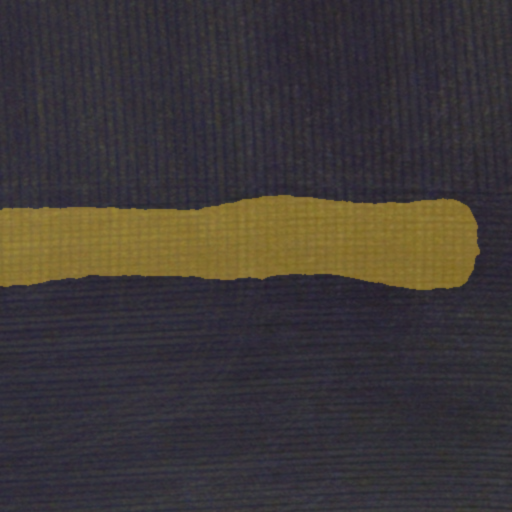

Predicted labels detected:
 - double_plant: color=(255, 200, 0), pixels=36018


Expected multi-label mask shape: torch.Size([8, 512, 512])


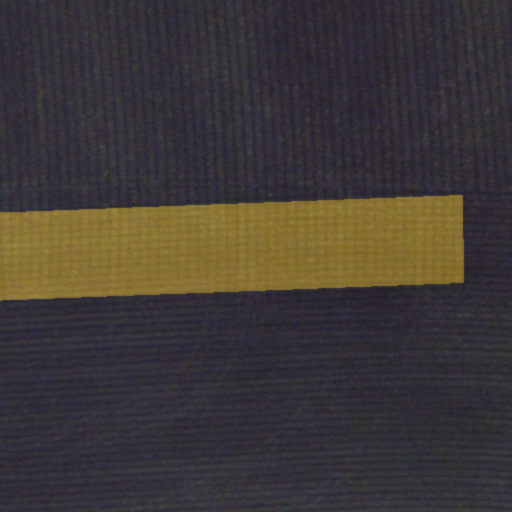

Ground-truth labels present:
 - double_plant: color=(255, 200, 0), pixels=40813


In [49]:
import random

random_val_id = random.choice(VAL_IMAGE_IDS)
validation_image_data = val_dataset.get_data(random_val_id)

print("Testing on image ID:", validation_image_data.image_id)
base_img = validation_image_data.image.load()
expected_mask = validation_image_data.mask.load()  # (C, H, W)

# Make prediction: return multi-label binary mask (C, H, W)
pred_bin_mask = predict_mask(validation_image_data, threshold=CONFIG['threshold'], as_class_index=False)

# Display predicted mask overlaid on the original image
print(f"Predicted multi-label mask shape: {pred_bin_mask.shape}")
display_mask(pred_bin_mask, palette=palette, base_image=base_img)

# Report which labels are detected in prediction with their colors and pixel counts
class_names = [label for label in LABELS if label not in EXCLUDE_LABELS]
detected_pred = []
for i, name in enumerate(class_names):
    pixels = int(pred_bin_mask[i].sum().item())
    if pixels > 0:
        detected_pred.append((name, palette[i], pixels))

if detected_pred:
    print("Predicted labels detected:")
    for name, color, pixels in detected_pred:
        print(f" - {name}: color={color}, pixels={pixels}")
else:
    print("No labels detected in prediction (threshold may be too high).")

print("\n==================\n")

# Display the expected (ground-truth) mask for comparison
# Ground-truth is multi-label (C, H, W); threshold at 0.5 to get binary presence
expected_bin_mask = (expected_mask > 0.5).cpu()
print(f"Expected multi-label mask shape: {expected_bin_mask.shape}")
display_mask(expected_bin_mask, palette=palette, base_image=base_img)

# Report which labels are present in ground-truth
detected_gt = []
for i, name in enumerate(class_names):
    pixels = int(expected_bin_mask[i].sum().item())
    if pixels > 0:
        detected_gt.append((name, palette[i], pixels))

if detected_gt:
    print("Ground-truth labels present:")
    for name, color, pixels in detected_gt:
        print(f" - {name}: color={color}, pixels={pixels}")
else:
    print("No labels present in ground-truth (unexpected).")